In [2]:
from numpy.random import normal
import numpy as np
from numpy.linalg import inv

from scipy import *
from scipy.linalg import norm, pinv
 

from sympy import symbols, diff
import matplotlib.pyplot as plt



In [3]:
def kmeans(x,k):
    n = x.shape[0]
    n_iterations = 1000
    epsilon = 1e-8
    err = np.inf

    #initialize random centroids
    c = np.zeros((k,2))
    for i in range(k):
        idx = np.random.randint(n)
        c[i] = x[idx,:]

    for iteration in range(n_iterations):
        d = np.zeros((n, k))  # distances to centroids square
        for i in range(k):
            d[:, i] = np.sqrt(np.sum(np.square(np.subtract(x, np.tile(c[i, :], (n, 1)))), 1).flatten())

        #assign each point to nearest centroid
        l = np.argmin(d,1)


        #recompute centroids as center of mass of each cluster
        for j in range(k):
            if len(l[l==j]):
                c[j,:] = x[l==j].sum(0) / len(l[l==j])

        err_new = np.sum(np.min(d,1))/n


        if np.abs(err_new - err)<epsilon:
            break
        err = err_new

    return c,l,err

In [14]:
np.random.seed(0)


#radial basis function compute exp(-beta * (c-x)^2)
def radialbasisfunc(beta, c, x):
    return exp(-beta * norm(c-x)**2)
     
#activation fills the Phi (in the pdf)
def activation(X, beta, numNeurons, centers):
    # calculate activations of RBFs
    Phi = zeros((X.shape[0], numNeurons), float)
    for i, c in enumerate(centers):
        for j, x in enumerate(X):
            #Here we fill the element j,i with exp(-beta * (c_i-x_j)^2)
            Phi[j,i] = radialbasisfunc(beta, c, x)
    return Phi
     
#trainrbf gives the values of the weights W and the covariance matrix Q
def trainrbf(X, Y, beta, numNeurons):
    
    #Dimensions
    #X: n x Inputdimension
    #y: n x 1
    
    #Centers are the neurons in our RBF network
    newCenters = kmeans(X,numNeurons)
    centers = newCenters[0]
    
    print "center", centers
    
    # calculate activations of RBFs
    Phi = activation(X, beta, numNeurons, centers)
    Phi = np.append(Phi, X, axis =1)
    Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis = 1)
        
    # calculate output weights (pseudoinverse)
    W = dot(pinv(Phi), Y)
    
    #Calculate the covariance matrix Q
    Q = (dot(np.transpose(Y),Y) - dot(np.transpose(W), dot(np.transpose(Phi), Y)))
    
    L = [W, Q, centers]
    
   
    print W
    print Q
    
    return L
         
def testrbf(X, W, Q, beta, numNeurons, centers):
    """ X: matrix of dimensions n x indim """
         
    Phi = activation(X, beta, numNeurons, centers)
    Phi = np.append(Phi, X, axis=1)
    Phi = np.append(Phi, np.ones((n,X.shape[1]), "float"), axis=1)
    Y = dot(Phi, W) + (1/X.shape[0])*random.normal(0, Q, X.shape[0])
    return Y



center [[ 1.91919192  1.91919192]
 [ 9.39393939  9.39393939]
 [ 0.70707071  0.70707071]
 [ 8.18181818  8.18181818]
 [-1.71717172 -1.71717172]
 [-5.95959596 -5.95959596]
 [ 6.06060606  6.06060606]
 [ 3.23232323  3.23232323]
 [-7.47474747 -7.47474747]
 [-0.2020202  -0.2020202 ]
 [-4.74747475 -4.74747475]
 [ 4.34343434  4.34343434]
 [ 7.37373737  7.37373737]
 [-3.83838384 -3.83838384]
 [-1.01010101 -1.01010101]
 [ 5.25252525  5.25252525]
 [-3.13131313 -3.13131313]
 [-9.19191919 -9.19191919]
 [ 6.76767677  6.76767677]
 [-2.42424242 -2.42424242]]
1
[[ -6.83292954]
 [ -0.52222599]
 [-32.18300148]
 [  1.02451748]
 [ -2.82154711]
 [  0.35961221]
 [  0.10200593]
 [  0.43098003]
 [  0.96339423]
 [-37.19518274]
 [  0.18467666]
 [  0.78248641]
 [ -0.36668142]
 [  0.79179958]
 [-17.57120136]
 [ -0.11984583]
 [  0.22910004]
 [  1.23746647]
 [  0.90194052]
 [ -1.20608792]
 [  0.90346269]
 [  0.24332279]]
[[ 122.95776322]]


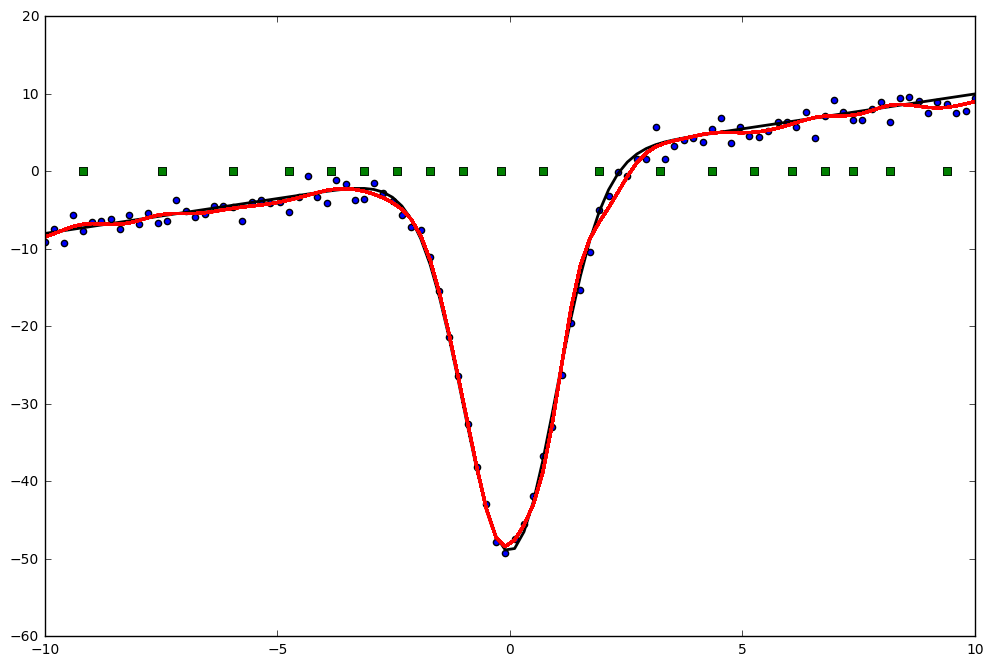

In [23]:
n = 100

#Specify Dimension of inputs and outputs
InputDimension = 1
OutputDimension = 1
     
#Define the bound of the focused interval    
lbound = -10
ubound = 10
    
x = mgrid[lbound:ubound:complex(0,n)].reshape(n, 1)
# set y and add random noise
    
    
#Function 1
#y = 0.01*x+20*np.sin(x)*np.exp(-x**2/2)

# function 2 : Well
yOriginal = 0.9*x-50*np.exp(-x**2/2)+1

yNoisy = yOriginal + random.normal(0, 1, yOriginal.shape)

     
#Initialize parameters of the radial basis function
    
#Number of Gaussian centers(Neurons)
numNeurons = 20

#Define the size of the kernels 
beta = 1


######### Start RBF regression #############

#Train the neural network on the data x
parameters = trainrbf(x, yNoisy , beta, numNeurons)
z = testrbf(x, parameters[0], parameters[1], beta, numNeurons, parameters[2])
       
# plot original data
plt.figure(figsize=(12, 8))

# plot original data
plt.plot(x,yOriginal, 'k-', linewidth=2)

for i in range(n):
    plt.scatter(x[i], yNoisy[i])
     
# plot learned model
plt.plot(x, z, 'r-', linewidth=2)
     
# plot rbfs
plt.plot(parameters[2], zeros(numNeurons), 'gs')
     
plt.xlim(lbound, ubound)
plt.show()

plt.savefig("graphs/RBF_2.eps",format = "eps")